<a href="https://colab.research.google.com/github/soumitrahazra/My_Data_Analysis_Codes/blob/main/cme_lasco_image_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Example of creating composite plots in sunpy with coronagraph maps**

In this short example, a method for creating a composite plot of the LASCO/C2 Corongraph image and an EUI 304 angstrom image.

In [17]:
from sunpy.net import Fido, attrs as a
import sunpy.map
from sunpy.coordinates import frames, sun
from sunpy.map.maputils import all_coordinates_from_map, coordinate_is_on_solar_disk
from sunpy.util.config import get_and_create_download_dir

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import  ImageNormalize, LogStretch
from astropy.constants import R_sun

import matplotlib.pyplot as plt
import numpy as np

In [27]:
import hvpy
from hvpy.datasource import DataSource
from datetime import datetime
from itipy.download.download_solo import SOLODownloader
import os
import glob

In [19]:
lasco_jp2_file = hvpy.save_file(hvpy.getJP2Image(datetime(2022, 2, 15, 12, 22),
                                                 DataSource.LASCO_C2.value),
                                filename=get_and_create_download_dir() + "/LASCO_C2.jp2", overwrite=True)

In [28]:
base_path = os.getcwd()
downloader = SOLODownloader(base_path=base_path+'/eui')
downloader.downloadDate(date=datetime(2022, 2, 15, 12, 22), FSI=True)
eui_files = sorted(glob.glob('eui/*/*.fits', recursive=True))

In [29]:
eui_files

['eui/eui-fsi174-image/2022-02-15T12:22:00.fits',
 'eui/eui-fsi304-image/2022-02-15T12:22:00.fits']

In [30]:
c2_map = sunpy.map.Map(lasco_jp2_file)
eui_map = sunpy.map.Map(eui_files[1])

Lets just rotate the EUI map and then add color normalization for plotting purposes

In [31]:
eui_map = eui_map.rotate(missing=eui_map.data.min())
eui_map.plot_settings["norm"] = ImageNormalize(vmin=0, vmax=500, stretch=LogStretch())

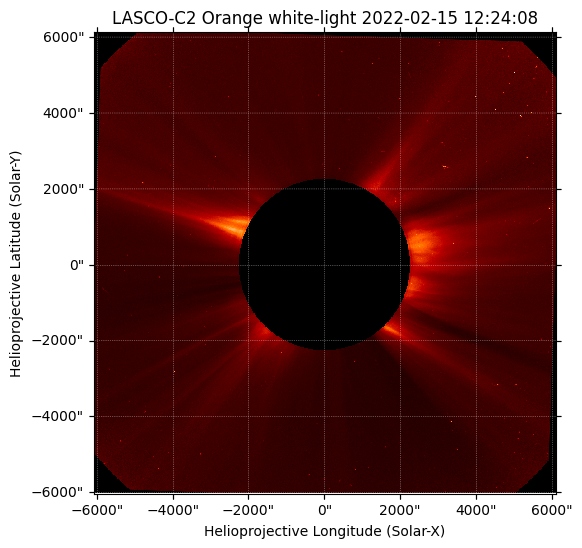

In [32]:
fig = plt.figure(figsize=(6, 6))
c2_map.plot()

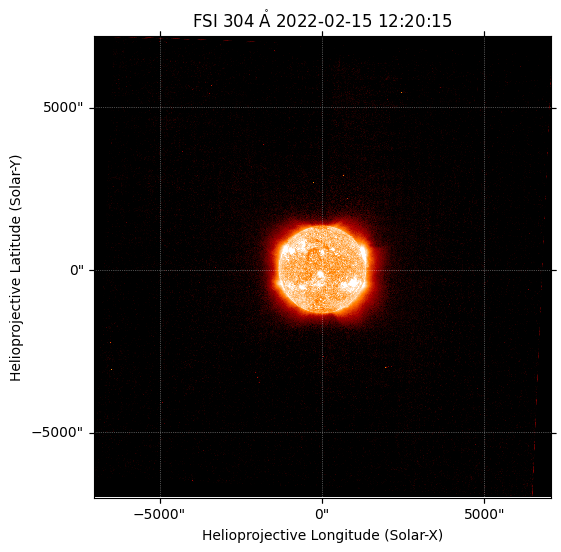

In [33]:
fig = plt.figure(figsize=(6, 6))
eui_map.plot()

Reproject the EUI map to the WCS of the LASCO C2.

In [38]:
with frames.Helioprojective.assume_spherical_screen(eui_map.observer_coordinate):
    eui_map_reproject = eui_map.reproject_to(c2_map.wcs)

        Use sunpy.coordinates.screens.SphericalScreen instead. [sunpy.util.decorators]
        Use sunpy.coordinates.screens.SphericalScreen instead.


We can mask out the coronagraph portion of the LASCO/C2 and then overplot the EUI image and the Lasco C2 image.

To do this, lets mask out the the points that lie 2.3 R_sun in LASCO/C2.

First we can use the utility function all_coordinates_from_map which gives us access to the helioprojective coordinate of each pixels.

In [34]:
hpc_coords = all_coordinates_from_map(c2_map)
rsun_coronagraph= 2.3*R_sun

Lets calculate the angular radius of coronagraph

In [35]:
distance = c2_map.observer_coordinate.transform_to(frames.HeliocentricInertial).spherical.distance
angular_radius_coronagraph = sun._angular_radius(rsun_coronagraph, distance)

We can now create a mask that will return a boolean whether the coordinate points on the map fall within this angular radius of the coronagraph. Then generate a masked LASCO/C2 Map! Also generate a colormap.

In [36]:
mask = np.sqrt(hpc_coords.Tx**2 + hpc_coords.Ty**2) < angular_radius_coronagraph
masked_c2_map = sunpy.map.Map(c2_map.data, c2_map.meta, mask=mask)

masked_cmap = masked_c2_map.cmap.copy()
masked_cmap.set_bad(alpha=0.)

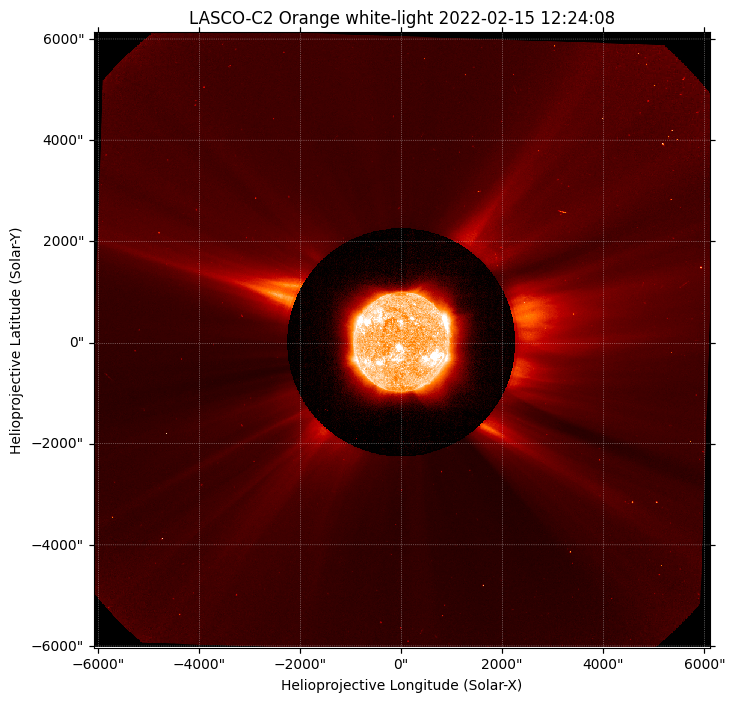

In [45]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection=masked_c2_map)
eui_map_reproject.plot()
masked_c2_map.plot(cmap=masked_cmap)
plt.savefig("lasco_c2_example.png")